In [1]:
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import gensim

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('../dmdlassignment2/AnnoMI/dataset.csv')
df.head()

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form t...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You dri...",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks whe...,therapist_input,NaN


# Data Cleaning and Preprocessing


In [3]:
import string
import re

stop_words = set(stopwords.words('english'))


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


def tokenize(text):
    split = re.split("\W+", text.lower())
    return split


def remove_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text


def lemmatize(text):
    lemmatized_words = []
    for word in text:
        lemmatized_words.append(lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_words)


In [4]:
# Remove null values
def transform(dataframe):
    for index, row in dataframe.iterrows():
        dataframe['avg_utterance_length'][index] = len(row['utterance_text'])
        words = word_tokenize(row['utterance_text'])

        dataframe['utterance_text'][index] = lemmatize(
            remove_stopwords(tokenize(remove_punctuation(row['utterance_text']))))

        if (pd.isnull(row['client_talk_type'])):
            dataframe['behaviour_type'][index] = row['main_therapist_behaviour']
        else:
            dataframe['behaviour_type'][index] = row['client_talk_type']


In [5]:
col = ['mi_quality', 'interlocutor', 'utterance_text',
       'main_therapist_behaviour', 'client_talk_type']
df = df[col]
df.insert(loc=5,
          column='avg_utterance_length',
          value=0)
df.insert(loc=5,
          column='behaviour_type',
          value='')

df_therapist = df[df['interlocutor'] == 'therapist']
df_client = df[df['interlocutor'] == 'client']

transform(df_therapist)
transform(df_client)

df_therapist.head()
df_client.head()


,mi_quality,interlocutor,utterance_text,main_therapist_behaviour,client_talk_type,behaviour_type,avg_utterance_length
1,high,client,sure,NaN,neutral,neutral,5
3,high,client,mmhmm,NaN,neutral,neutral,7
5,high,client,usually three drink glass wine,NaN,neutral,neutral,41
7,high,client,something like,NaN,neutral,neutral,20
9,high,client,okay,NaN,neutral,neutral,5


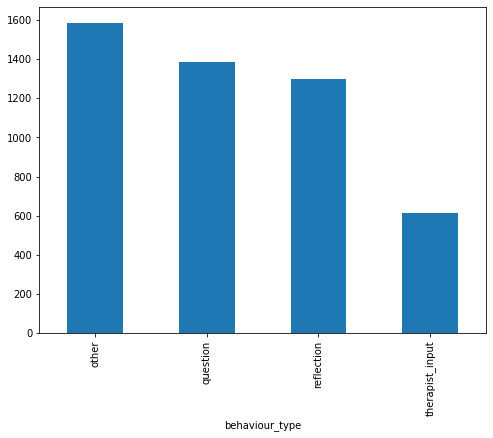

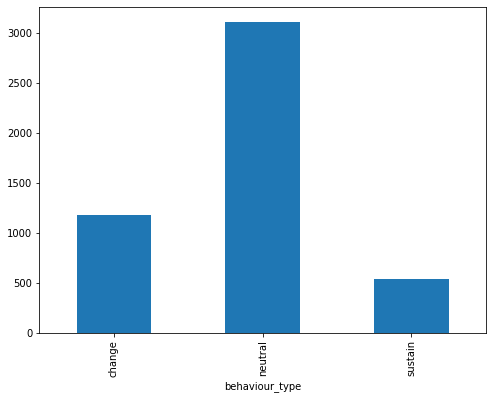

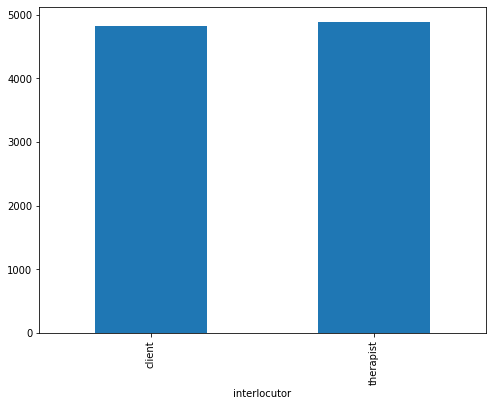

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
df_therapist.groupby('behaviour_type').interlocutor.count().plot.bar(ylim=0)
plt.show()

fig = plt.figure(figsize=(8, 6))
df_client.groupby('behaviour_type').interlocutor.count().plot.bar(ylim=0)
plt.show()

fig = plt.figure(figsize=(8, 6))
df.groupby('interlocutor').avg_utterance_length.count().plot.bar(ylim=0)
plt.show()


In [6]:
processed_data = {'therapist': {}, 'client': {}}


def extract_labels(dataframe, key):
    dataframe['behaviour_type_id'] = dataframe['behaviour_type'].factorize()[0]
    processed_data[key]['behaviour_type_id_df'] = dataframe[['behaviour_type',
                                                             'behaviour_type_id']].drop_duplicates().sort_values('behaviour_type_id')
    processed_data[key]['behaviour_to_id'] = dict(
        processed_data[key]['behaviour_type_id_df'].values)
    processed_data[key]['id_to_behaviour'] = dict(processed_data[key]['behaviour_type_id_df'][[
                                                  'behaviour_type_id', 'behaviour_type']].values)


In [7]:
extract_labels(df_therapist, 'therapist')
extract_labels(df_client, 'client')


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


def data_shape(dataframe, key):
    processed_data[key]['tfidf'] = TfidfVectorizer(
        sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    processed_data[key]['features'] = processed_data[key]['tfidf'].fit_transform(
        dataframe.utterance_text).toarray()
    processed_data[key]['labels'] = dataframe.behaviour_type_id
    print(processed_data[key]['features'].shape)


In [9]:
data_shape(df_therapist, 'therapist')
data_shape(df_client, 'client')


(4882, 1369)
(4817, 1236)


## Extract the features and labels from the dataset


In [10]:
from sklearn.feature_selection import chi2
import numpy as np


def extract_features(dataframe, key):
    N = 2
    for behaviour_type, behaviour_type_id in sorted(processed_data[key]['behaviour_to_id'].items()):
        features_chi2 = chi2(
            processed_data[key]['features'], processed_data[key]['labels'] == behaviour_type_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(
            processed_data[key]['tfidf'].get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        print("------------------------------------------------------------------")
        print(key)
        print("------------------------------------------------------------------")
        print("# '{}':".format(behaviour_type))
        print("  . Most correlated unigrams:\n. {}".format(
            '\n. '.join(unigrams[-N:])))
        print("  . Most correlated bigrams:\n. {}".format(
            '\n. '.join(bigrams[-N:])))


In [11]:
extract_features(df_therapist, 'therapist')
extract_features(df_client, 'client')


/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/nandangrover/miniforge3/

------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'other':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. sound like
. yeah yeah
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'question':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. scale 10
. tell little
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'reflection':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. feel like
. sound like
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'therapist_input':
  . Most correlated unigrams:
. know
. mmhmm
  . Most correlated 

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## BERT Transformer Model

Overfitting was reduced by increasing Dropout rate and introducing Early Stopping.

In [12]:
import transformers
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')


def construct_model(dataframe, key, shape):
    x_train, processed_data[key]['x_test'], y_train, processed_data[key]['y_test'], indices_train, processed_data[key]['indices_test'] = train_test_split(
        dataframe.utterance_text, processed_data[key]['labels'], dataframe.index, test_size=0.33, random_state=0)
    y_train = to_categorical(y_train)
    processed_data[key]['y_test'] = to_categorical(
        processed_data[key]['y_test'])

    x_train = tokenizer(
        text=x_train.tolist(),
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)
    processed_data[key]['x_test'] = tokenizer(
        text=processed_data[key]['x_test'].tolist(),
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

    input_ids = x_train['input_ids']
    attention_mask = x_train['attention_mask']

    max_len = 70
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    embeddings = bert(input_ids, attention_mask=input_mask)[0]
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = Dense(128, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(8, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    y = Dense(shape, activation='sigmoid')(out)
    processed_data[key]['model'] = tf.keras.Model(
        inputs=[input_ids, input_mask], outputs=y)
    processed_data[key]['model'].layers[2].trainable = True

    optimizer = Adam(
        # This learning rate is for bert model, taken from huggingface website
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)
    # Set loss and metrics
    loss = CategoricalCrossentropy(from_logits=True)
    metric = CategoricalAccuracy('balanced_accuracy'),
    # Compile the model
    processed_data[key]['model'].compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metric)

    callback = tf.keras.callbacks.EarlyStopping(monitor="val_balanced_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

    processed_data[key]['train_history'] = processed_data[key]['model'].fit(
        x={'input_ids': x_train['input_ids'],
            'attention_mask': x_train['attention_mask']},
        y=y_train,
        validation_data=(
            {'input_ids': processed_data[key]['x_test']['input_ids'],
                'attention_mask': processed_data[key]['x_test']['attention_mask']}, processed_data[key]['y_test']
        ),
        epochs=30,
        callbacks=[callback],
        batch_size = 36
    )


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-15 15:21:51.170313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-15 15:21:51.170431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identica

In [23]:
construct_model(df_therapist, 'therapist', 4)

Epoch 1/30


2022-05-15 13:08:24.015489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 1.1992 - balanced_accuracy: 0.4498

2022-05-15 13:10:59.058200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 187s 2s/step - loss: 1.1992 - balanced_accuracy: 0.4498 - val_loss: 1.0619 - val_balanced_accuracy: 0.5124
Epoch 2/30
91/91 [==============================] - 104s 1s/step - loss: 1.0948 - balanced_accuracy: 0.5028 - val_loss: 0.9819 - val_balanced_accuracy: 0.5248
Epoch 3/30
91/91 [==============================] - 115s 1s/step - loss: 1.0636 - balanced_accuracy: 0.5122 - val_loss: 0.9670 - val_balanced_accuracy: 0.5273
Epoch 4/30
91/91 [==============================] - 111s 1s/step - loss: 1.0111 - balanced_accuracy: 0.5278 - val_loss: 0.9806 - val_balanced_accuracy: 0.5881
Epoch 5/30
91/91 [==============================] - 113s 1s/step - loss: 0.9793 - balanced_accuracy: 0.5410 - val_loss: 0.9647 - val_balanced_accuracy: 0.5751
Epoch 6/30
91/91 [==============================] - 112s 1s/step - loss: 0.9536 - balanced_accuracy: 0.5511 - val_loss: 0.9481 - val_balanced_accuracy: 0.6135
Epoch 7/30
91/91 [==============================] - 112s 

In [24]:
import matplotlib.pyplot as plt

def plot_convergence(history, key):
    plt.plot(history.history['balanced_accuracy'])
    plt.plot(history.history['val_balanced_accuracy'])
    plt.title('Model Accuracy for {}'.format(key))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss for {}'.format(key))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

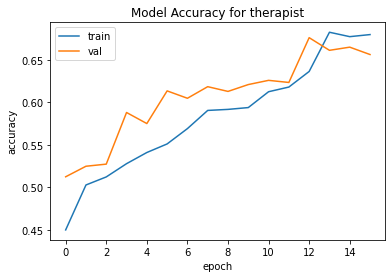

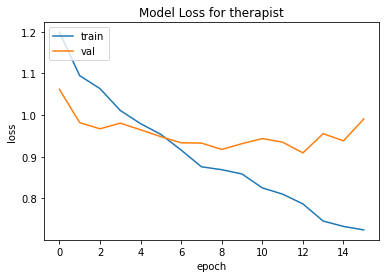

In [25]:
plot_convergence(processed_data['therapist']['train_history'], 'therapist')

In [26]:
predicted_raw = processed_data['therapist']['model'].predict(
    {'input_ids': processed_data['therapist']['x_test']['input_ids'], 'attention_mask': processed_data['therapist']['x_test']['attention_mask']})
predicted_raw[0]

2022-05-15 13:39:13.925146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0.92701685, 0.09708139, 0.7790912 , 0.10547308], dtype=float32)

In [43]:
y_predicted = (predicted_raw == predicted_raw.max(axis=1, keepdims=1)).astype(float)
y_true =  processed_data['therapist']['y_test']

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_predicted, target_names=df_therapist['behaviour_type'].unique()))

                 precision    recall  f1-score   support

       question       0.64      0.57      0.61       438
therapist_input       0.55      0.53      0.54       232
     reflection       0.58      0.68      0.63       453
          other       0.88      0.83      0.85       489

      micro avg       0.68      0.68      0.68      1612
      macro avg       0.66      0.65      0.66      1612
   weighted avg       0.68      0.68      0.68      1612
    samples avg       0.68      0.68      0.68      1612



In [13]:
construct_model(df_client, 'client', 3)

Epoch 1/30


2022-05-15 15:22:54.770573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2022-05-15 15:23:01.671216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.9051 - balanced_accuracy: 0.6284

2022-05-15 15:24:51.898722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 135s 1s/step - loss: 0.9051 - balanced_accuracy: 0.6284 - val_loss: 0.8566 - val_balanced_accuracy: 0.6352
Epoch 2/30
90/90 [==============================] - 117s 1s/step - loss: 0.8642 - balanced_accuracy: 0.6219 - val_loss: 0.8272 - val_balanced_accuracy: 0.6516
Epoch 3/30
90/90 [==============================] - 116s 1s/step - loss: 0.8195 - balanced_accuracy: 0.6303 - val_loss: 0.8143 - val_balanced_accuracy: 0.6503
Epoch 4/30
90/90 [==============================] - 115s 1s/step - loss: 0.7660 - balanced_accuracy: 0.6625 - val_loss: 0.8142 - val_balanced_accuracy: 0.6302
Epoch 5/30
90/90 [==============================] - 107s 1s/step - loss: 0.7236 - balanced_accuracy: 0.6870 - val_loss: 0.7988 - val_balanced_accuracy: 0.6428
Epoch 5: early stopping


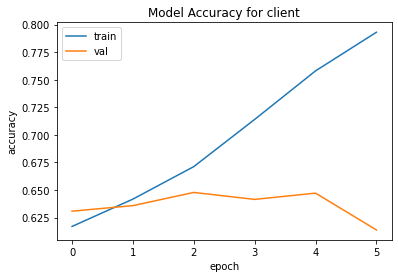

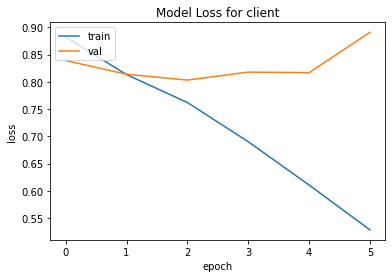

In [54]:
plot_convergence(processed_data['client']['train_history'], 'client')

In [14]:
predicted_raw = processed_data['client']['model'].predict(
    {'input_ids': processed_data['client']['x_test']['input_ids'], 'attention_mask': processed_data['client']['x_test']['attention_mask']})
predicted_raw[0]

2022-05-15 17:06:01.790415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0.7357803 , 0.5635742 , 0.37461808], dtype=float32)

In [20]:
y_predicted = (predicted_raw == predicted_raw.max(axis=1, keepdims=1)).astype(float)
y_true =  processed_data['client']['y_test']

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [23]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_predicted, zero_division=False, target_names=df_client['behaviour_type'].unique()))

              precision    recall  f1-score   support

     neutral       0.68      0.92      0.78      1003
      change       0.48      0.27      0.35       403
     sustain       0.00      0.00      0.00       184

   micro avg       0.65      0.65      0.65      1590
   macro avg       0.39      0.40      0.38      1590
weighted avg       0.55      0.65      0.58      1590
 samples avg       0.65      0.65      0.65      1590

